In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from lightgbm import LGBMClassifier 
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, BaseEnsemble, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import eli5
import shap
from sklearn import model_selection

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

In [2]:
data = pd.read_csv('../data/data_full_final.csv')

In [3]:
traincols = list(data.columns)
traincols.remove('RESULT')

In [4]:
print (len(traincols))

713


In [5]:
train = pd.read_csv('../data/CAX_MortgageModeling_Train.csv')
train_len = train.shape[0]

In [6]:
train = data.iloc[:train_len]
test = data.iloc[train_len:]

In [7]:
train_embeddings = pd.read_csv('../data/train_AE_embeddings.csv')
test_embeddings = pd.read_csv('../data/test_AE_embeddings.csv')

In [8]:
train = pd.concat([train,train_embeddings],axis=1)
test = pd.concat([test,test_embeddings],axis=1)

In [9]:
traincols = list(train.columns)
traincols.remove('RESULT')
for col in traincols:
    if train[col].nunique() == 1 or test[col].nunique() == 1:
        traincols.remove(col)

In [10]:
print (len(traincols))

713


In [11]:
train2 = pd.concat([train[train.RESULT == 0].sample(frac=.3,random_state=123),train[train.RESULT == 1]],axis=0).sample(frac=1,random_state=123)

In [12]:
train2.head(10)

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,MORTGAGE AMOUNT,RATE,AGE RANGE,INCOME,CREDIT SCORE,RESULT,APPRAISED PROPERTY VALUE,CHANGE IN PROPERTY VALUE,ANNUALIZED HOUSING EXPENSE,MORTGAGE RATIO,OTHER EXPENSE,RENT INCOME,ACTUAL MORTGAGE PAYMENT,TOTAL INTEREST,MORTGAGE AMOUNT PER INCOME,MORTGAGE PAYMENT PER INCOME,PROPERTY VALUE PER INCOME,TOTAL INTEREST PER INCOME,OTHER EXPENSE PER INCOME,ANNUALIZED HOUSING EXPENSE PER INCOME,ACTUAL MORTGAGE PAYMENT BY MORTGAGE,PROPERTY VALUE MORTGAGE PURPOSE MEAN,PROPERTY VALUE MORTGAGE PURPOSE VAR,PROPERTY VALUE MORTGAGE PURPOSE Z SCORE,MORTGAGE PAYMENT MORTGAGE PURPOSE MEAN,MORTGAGE PAYMENT MORTGAGE PURPOSE VAR,MORTGAGE PAYMENT MORTGAGE PURPOSE Z SCORE,GDS MORTGAGE PURPOSE MEAN,GDS MORTGAGE PURPOSE VAR,GDS MORTGAGE PURPOSE Z SCORE,LTV MORTGAGE PURPOSE MEAN,LTV MORTGAGE PURPOSE VAR,LTV MORTGAGE PURPOSE Z SCORE,TDS MORTGAGE PURPOSE MEAN,TDS MORTGAGE PURPOSE VAR,TDS MORTGAGE PURPOSE Z SCORE,MORTGAGE AMOUNT MORTGAGE PURPOSE MEAN,MORTGAGE AMOUNT MORTGAGE PURPOSE VAR,MORTGAGE AMOUNT MORTGAGE PURPOSE Z SCORE,INCOME MORTGAGE PURPOSE MEAN,INCOME MORTGAGE PURPOSE VAR,INCOME MORTGAGE PURPOSE Z SCORE,CREDIT SCORE MORTGAGE PURPOSE MEAN,CREDIT SCORE MORTGAGE PURPOSE VAR,CREDIT SCORE MORTGAGE PURPOSE Z SCORE,APPRAISED PROPERTY VALUE MORTGAGE PURPOSE MEAN,APPRAISED PROPERTY VALUE MORTGAGE PURPOSE VAR,APPRAISED PROPERTY VALUE MORTGAGE PURPOSE Z SCORE,CHANGE IN PROPERTY VALUE MORTGAGE PURPOSE MEAN,CHANGE IN PROPERTY VALUE MORTGAGE PURPOSE VAR,CHANGE IN PROPERTY VALUE MORTGAGE PURPOSE Z SCORE,ANNUALIZED HOUSING EXPENSE MORTGAGE PURPOSE MEAN,ANNUALIZED HOUSING EXPENSE MORTGAGE PURPOSE VAR,ANNUALIZED HOUSING EXPENSE MORTGAGE PURPOSE Z SCORE,MORTGAGE RATIO MORTGAGE PURPOSE MEAN,MORTGAGE RATIO MORTGAGE PURPOSE VAR,MORTGAGE RATIO MORTGAGE PURPOSE Z SCORE,OTHER EXPENSE MORTGAGE PURPOSE MEAN,OTHER EXPENSE MORTGAGE PURPOSE VAR,OTHER EXPENSE MORTGAGE PURPOSE Z SCORE,ACTUAL MORTGAGE PAYMENT MORTGAGE PURPOSE MEAN,ACTUAL MORTGAGE PAYMENT MORTGAGE PURPOSE VAR,ACTUAL MORTGAGE PAYMENT MORTGAGE PURPOSE Z SCORE,TOTAL INTEREST MORTGAGE PURPOSE MEAN,TOTAL INTEREST MORTGAGE PURPOSE VAR,TOTAL INTEREST MORTGAGE PURPOSE Z SCORE,MORTGAGE AMOUNT PER INCOME MORTGAGE PURPOSE MEAN,MORTGAGE AMOUNT PER INCOME MORTGAGE PURPOSE VAR,MORTGAGE AMOUNT PER INCOME MORTGAGE PURPOSE Z SCORE,MORTGAGE PAYMENT PER INCOME MORTGAGE PURPOSE MEAN,MORTGAGE PAYMENT PER INCOME MORTGAGE PURPOSE VAR,MORTGAGE PAYMENT PER INCOME MORTGAGE PURPOSE Z SCORE,PROPERTY VALUE PER INCOME MORTGAGE PURPOSE MEAN,PROPERTY VALUE PER INCOME MORTGAGE PURPOSE VAR,PROPERTY VALUE PER INCOME MORTGAGE PURPOSE Z SCORE,TOTAL INTEREST PER INCOME MORTGAGE PURPOSE MEAN,TOTAL INTEREST PER INCOME MORTGAGE PURPOSE VAR,TOTAL INTEREST PER INCOME MORTGAGE PURPOSE Z SCORE,OTHER EXPENSE PER INCOME MORTGAGE PURPOSE MEAN,OTHER EXPENSE PER INCOME MORTGAGE PURPOSE VAR,OTHER EXPENSE PER INCOME MORTGAGE PURPOSE Z SCORE,ANNUALIZED HOUSING EXPENSE PER INCOME MORTGAGE PURPOSE MEAN,ANNUALIZED HOUSING EXPENSE PER INCOME MORTGAGE PURPOSE VAR,ANNUALIZED HOUSING EXPENSE PER INCOME MORTGAGE PURPOSE Z SCORE,ACTUAL MORTGAGE PAYMENT BY MORTGAGE MORTGAGE PURPOSE MEAN,ACTUAL MORTGAGE PAYMENT BY MORTGAGE MORTGAGE PURPOSE VAR,ACTUAL MORTGAGE PAYMENT BY MORTGAGE MORTGAGE PURPOSE Z SCORE,PROPERTY VALUE PAYMENT FREQUENCY MEAN,PROPERTY VALUE PAYMENT FREQUENCY VAR,PROPERTY VALUE PAYMENT FREQUENCY Z SCORE,MORTGAGE PAYMENT PAYMENT FREQUENCY MEAN,MORTGAGE PAYMENT PAYMENT FREQUENCY VAR,MORTGAGE PAYMENT PAYMENT FREQUENCY Z SCORE,GDS PAYMENT FREQUENCY MEAN,GDS PAYMENT FREQUENCY VAR,GDS PAYMENT FREQUENCY Z SCORE,LTV PAYMENT FREQUENCY MEAN,LTV PAYMENT FREQUENCY VAR,LTV PAYMENT FREQUENCY Z SCORE,TDS PAYMENT FREQUENCY MEAN,TDS PAYMENT FREQUENCY VAR,TDS PAYMENT FREQUENCY Z SCORE,MORTGAGE AMOUNT PAYMENT FREQUENCY MEAN,MORTGAGE AMOUNT PAYMENT FREQUENCY VAR,MORTGAGE AMOUNT PAYMENT FREQUENCY Z SCORE,INCOME PAYMENT FREQUENCY MEAN,INCOME PAYMENT FREQUENCY VAR,INCOME PAYMENT FREQUENCY Z SCORE,CREDIT SCORE PAYMENT FREQUENCY MEAN,CREDIT SCOR

In [13]:
kf = KFold(n_splits=5,random_state=123,shuffle=True)
for train_index, test_index in kf.split(train):
    break
for train_index2, test_index2 in kf.split(train2):
    break

In [14]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(train2[traincols].iloc[train_index2], train2.RESULT.iloc[train_index2])
pred = rf.predict(train2[traincols].iloc[test_index2])
print (accuracy_score(train2.RESULT.iloc[test_index2],pred))
print (confusion_matrix(train2.RESULT.iloc[test_index2],pred))
print (f1_score(train2.RESULT.iloc[test_index2],pred))

0.6510034263338228
[[1481  685]
 [ 741 1179]]
0.6231501057082451


In [19]:
importances = rf.feature_importances_
indices = importances.argsort()[::-1]
cols = traincols
count = 0
important_columns = []
for i in range(len(cols)):
    count += 1
    if importances[indices[i]] > 0 and count < 50:
        print ("Column {} has importance {}".format(cols[indices[i]],importances[indices[i]]))
        important_columns.append(cols[indices[i]])

Column CHANGE IN PROPERTY VALUE PAYMENT FREQUENCY Z SCORE has importance 0.0071135528075884575
Column CHANGE IN PROPERTY VALUE MORTGAGE PURPOSE Z SCORE has importance 0.006870075861981146
Column CHANGE IN PROPERTY VALUE has importance 0.006703219148625175
Column TOTAL INTEREST FSA Z SCORE has importance 0.006379967006193524
Column ACTUAL MORTGAGE PAYMENT FSA Z SCORE has importance 0.006233177877164618
Column APPRAISED PROPERTY VALUE FSA Z SCORE has importance 0.006047533792112323
Column TDS MORTGAGE PURPOSE Z SCORE has importance 0.005729885611317449
Column TDS PAYMENT FREQUENCY Z SCORE has importance 0.005258025691192643
Column PROPERTY VALUE FSA Z SCORE has importance 0.0051407125236251705
Column TDS has importance 0.005032651238045453
Column CHANGE IN PROPERTY VALUE GENDER Z SCORE has importance 0.004891743210192379
Column umap_1 has importance 0.004826223784527458
Column MORTGAGE AMOUNT FSA Z SCORE has importance 0.004809073330237012
Column CHANGE IN PROPERTY VALUE PROPERTY TYPE Z 

In [20]:
important_columns

['CHANGE IN PROPERTY VALUE PAYMENT FREQUENCY Z SCORE',
 'CHANGE IN PROPERTY VALUE MORTGAGE PURPOSE Z SCORE',
 'CHANGE IN PROPERTY VALUE',
 'TOTAL INTEREST FSA Z SCORE',
 'ACTUAL MORTGAGE PAYMENT FSA Z SCORE',
 'APPRAISED PROPERTY VALUE FSA Z SCORE',
 'TDS MORTGAGE PURPOSE Z SCORE',
 'TDS PAYMENT FREQUENCY Z SCORE',
 'PROPERTY VALUE FSA Z SCORE',
 'TDS',
 'CHANGE IN PROPERTY VALUE GENDER Z SCORE',
 'umap_1',
 'MORTGAGE AMOUNT FSA Z SCORE',
 'CHANGE IN PROPERTY VALUE PROPERTY TYPE Z SCORE',
 'CREDIT SCORE NAICS CODE Z SCORE',
 'CREDIT SCORE FSA Z SCORE',
 'AE_4',
 'umap_2',
 'CREDIT SCORE AGE RANGE Z SCORE',
 'CHANGE IN PROPERTY VALUE NAICS CODE Z SCORE',
 'TOTAL INTEREST NAICS CODE Z SCORE',
 'AE_6',
 'CREDIT SCORE GENDER Z SCORE',
 'TDS FSA Z SCORE',
 'CREDIT SCORE MORTGAGE PURPOSE Z SCORE',
 'AE_16',
 'TDS GENDER Z SCORE',
 'CHANGE IN PROPERTY VALUE AGE RANGE Z SCORE',
 'CREDIT SCORE PAYMENT FREQUENCY Z SCORE',
 'ACTUAL MORTGAGE PAYMENT NAICS CODE Z SCORE',
 'CREDIT SCORE PROPERTY TYPE Z SCORE',
 'AE_9',
 'CREDIT SCORE',
 'CHANGE IN PROPERTY VALUE FSA Z SCORE',
 'AE_5',
 'MORTGAGE PAYMENT FSA Z SCORE',
 'TDS NAICS CODE Z SCORE',
 'AE_11',
 'TDS PROPERTY TYPE Z SCORE',
 'AE_1',
 'AE_20',
 'TDS AGE RANGE Z SCORE',
 'APPRAISED PROPERTY VALUE PROPERTY TYPE Z SCORE',
 'AE_8',
 'AE_10',
 'AE_15',
 'AE_2',
 'GDS MORTGAGE PURPOSE Z SCORE',
 'APPRAISED PROPERTY VALUE NAICS CODE Z SCORE']

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

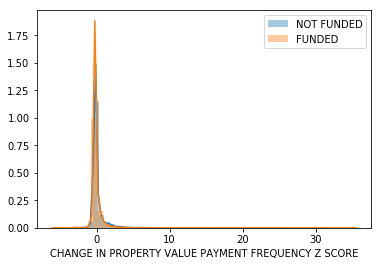

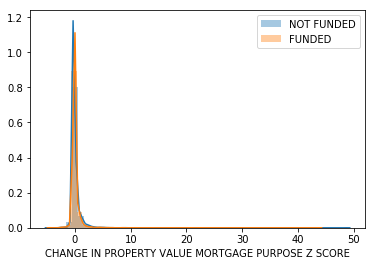

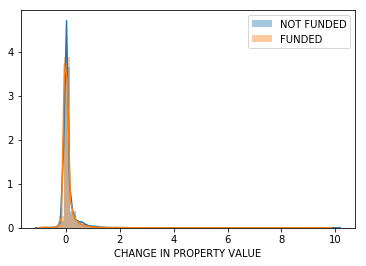

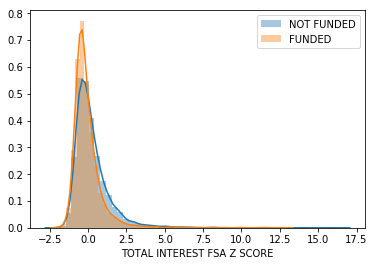

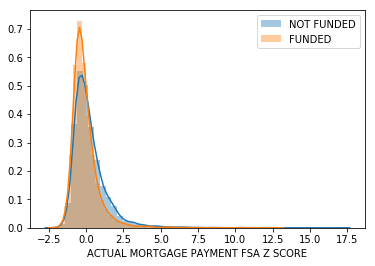

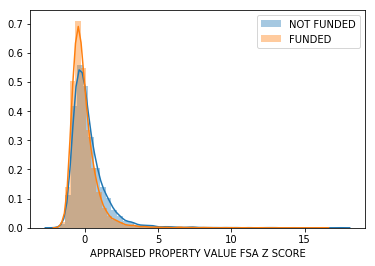

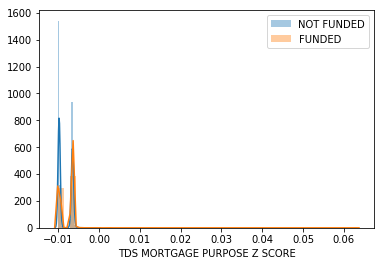

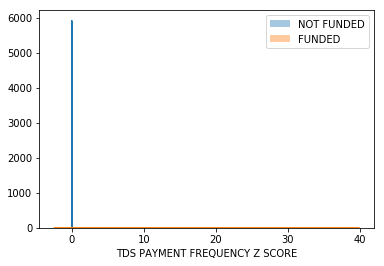

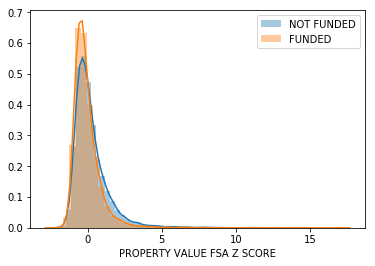

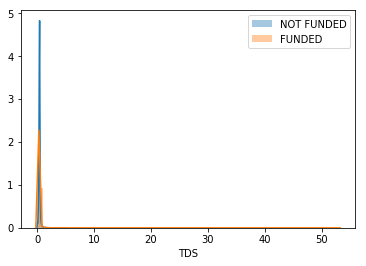

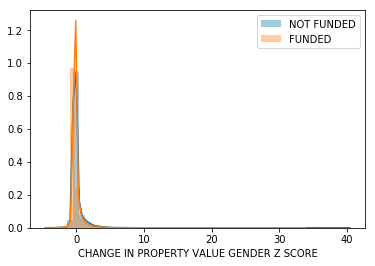

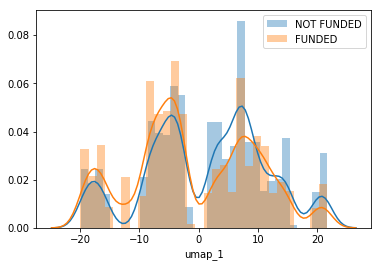

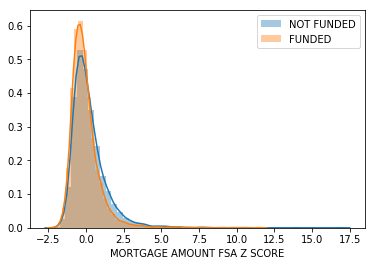

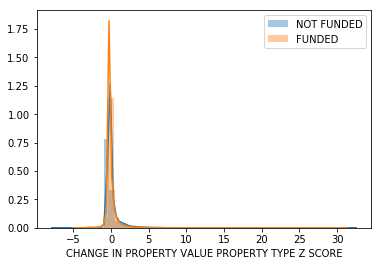

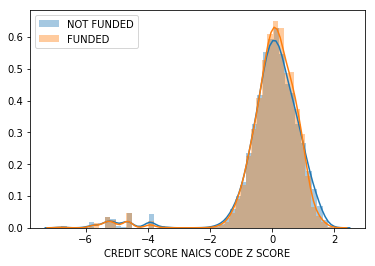

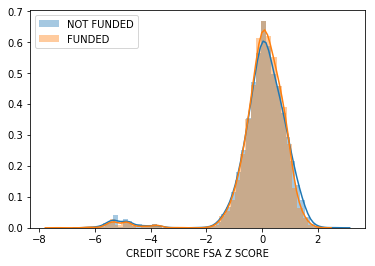

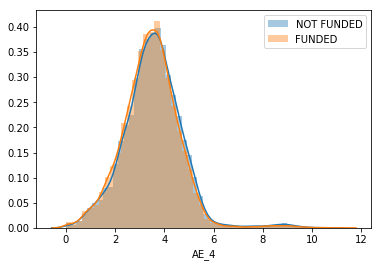

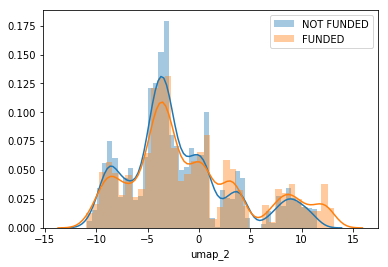

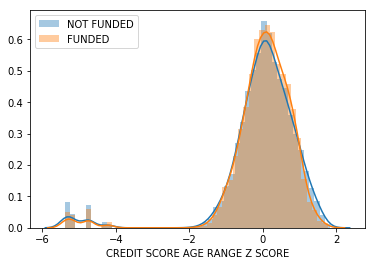

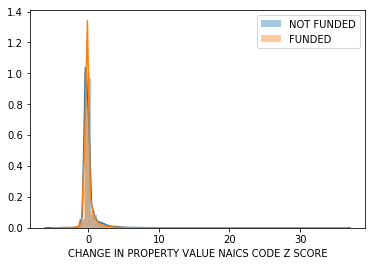

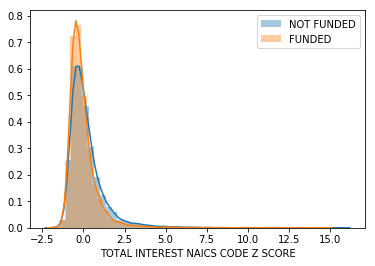

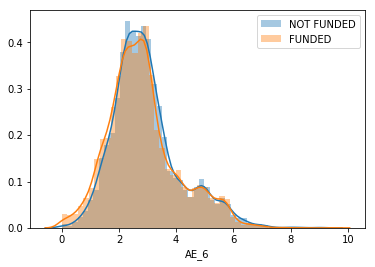

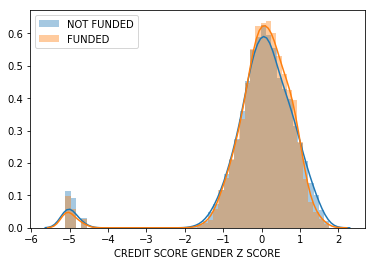

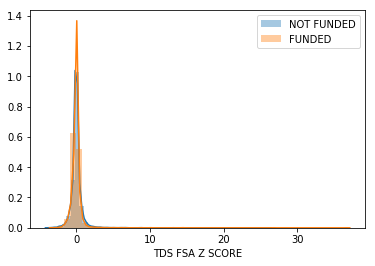

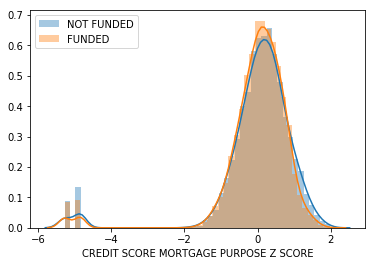

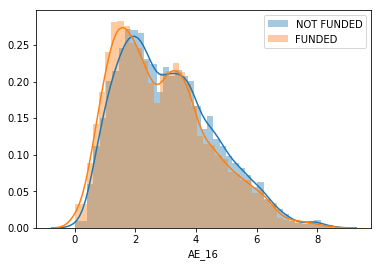

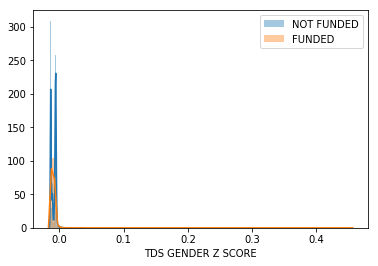

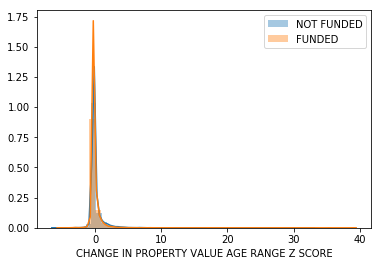

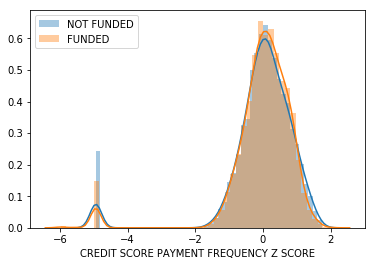

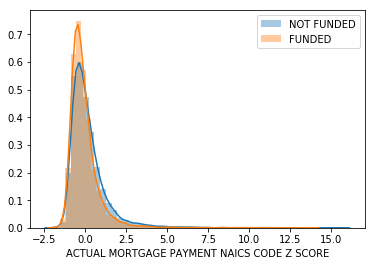

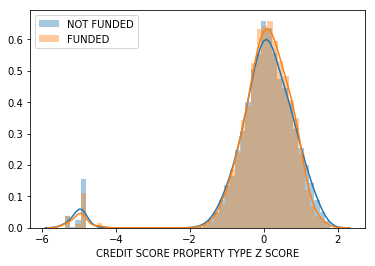

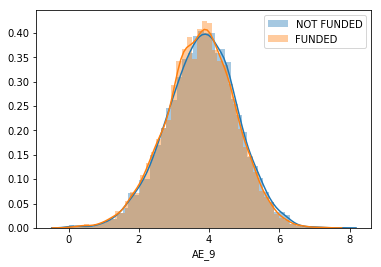

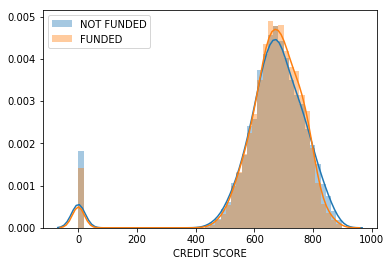

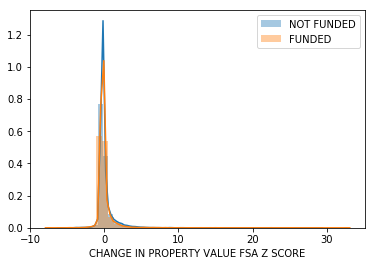

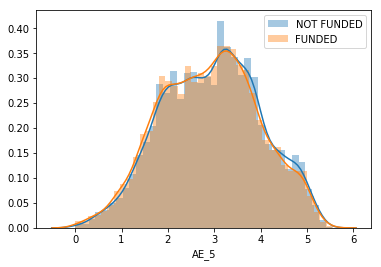

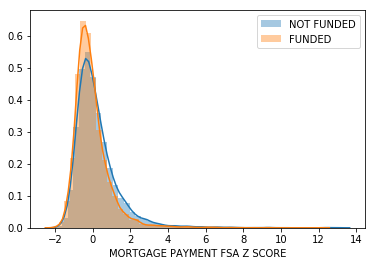

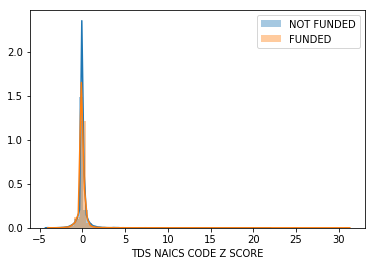

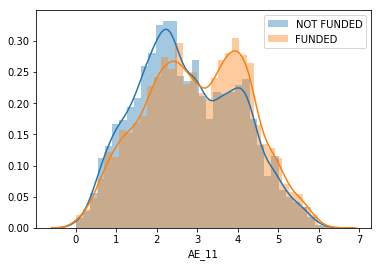

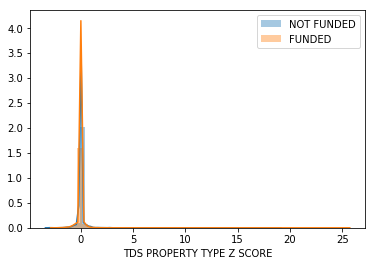

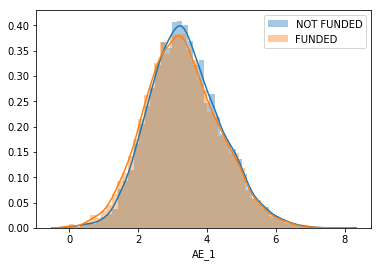

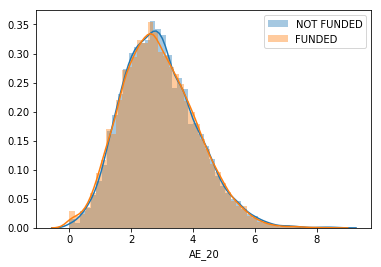

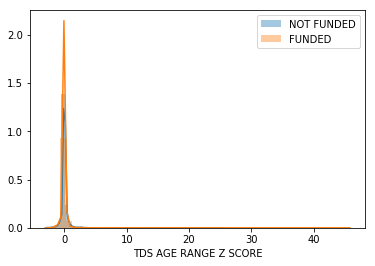

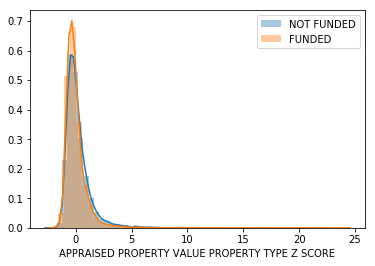

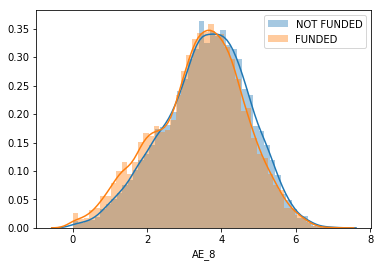

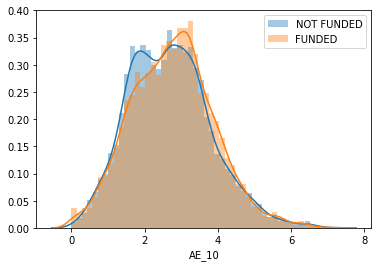

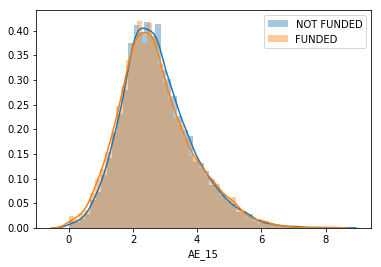

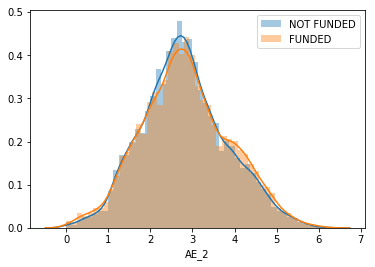

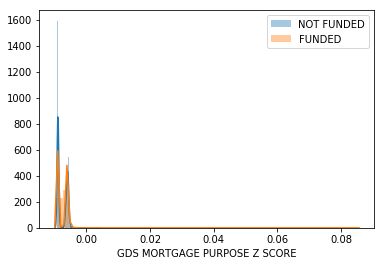

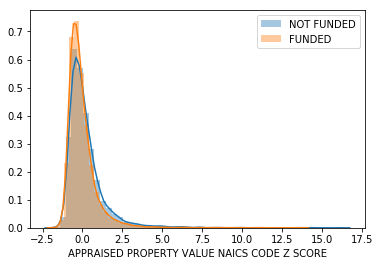

In [21]:
for col in important_columns:
    sns.distplot(train2[train2.RESULT == 1][col],kde=True,label='NOT FUNDED')
    sns.distplot(train2[train2.RESULT == 0][col],kde=True,label='FUNDED')
    plt.legend()
    plt.xlabel(col)
    plt.show()

In [30]:
lgb = LGBMClassifier(max_depth=24, n_estimators=869, colsample_bytree=0.7718959178260887, learning_rate=0.09428233648811904,random_state=42)
lgb.fit(train2[traincols].iloc[train_index2], train2.RESULT.iloc[train_index2])
pred = lgb.predict(train2[traincols].iloc[test_index2])
print (accuracy_score(train2.RESULT.iloc[test_index2],pred))
print (confusion_matrix(train2.RESULT.iloc[test_index2],pred))
print (f1_score(train2.RESULT.iloc[test_index2],pred))

0.6659324522760646
[[1530  636]
 [ 729 1191]]
0.6357085668534828


In [28]:
importances = lgb.feature_importances_
indices = importances.argsort()[::-1]
cols = traincols
count = 0
for i in range(len(cols)):
    count += 1
    if importances[indices[i]] > 0 and count < 50:
        print ("Column {} has importance {}".format(cols[indices[i]],importances[indices[i]]))

Column AE_19 has importance 291
Column AE_8 has importance 269
Column AE_7 has importance 268
Column AE_16 has importance 255
Column AE_4 has importance 255
Column AE_13 has importance 249
Column AE_3 has importance 248
Column AE_5 has importance 244
Column AE_18 has importance 242
Column AE_9 has importance 228
Column CHANGE IN PROPERTY VALUE PAYMENT FREQUENCY Z SCORE has importance 227
Column TDS FSA Z SCORE has importance 224
Column AE_17 has importance 218
Column TDS NAICS CODE Z SCORE has importance 210
Column umap_2 has importance 209
Column AE_14 has importance 204
Column GDS AGE RANGE Z SCORE has importance 197
Column TDS PROPERTY TYPE Z SCORE has importance 196
Column ANNUALIZED HOUSING EXPENSE AGE RANGE Z SCORE has importance 186
Column CREDIT SCORE FSA Z SCORE has importance 184
Column CHANGE IN PROPERTY VALUE MORTGAGE PURPOSE Z SCORE has importance 183
Column TDS has importance 181
Column MORTGAGE RATIO FSA Z SCORE has importance 181
Column TDS AGE RANGE Z SCORE has importa

In [31]:
xgb = XGBClassifier(n_estimators=1000,random_state=42)
xgb.fit(train2[traincols].iloc[train_index2], train2.RESULT.iloc[train_index2])
pred = xgb.predict(train2[traincols].iloc[test_index2])
print (accuracy_score(train2.RESULT.iloc[test_index2],pred))
print (confusion_matrix(train2.RESULT.iloc[test_index2],pred))
print (f1_score(train2.RESULT.iloc[test_index2],pred))

0.6622613803230544
[[1526  640]
 [ 740 1180]]
0.6310160427807486


In [32]:
importances = xgb.feature_importances_
indices = importances.argsort()[::-1]
cols = traincols
count = 0
for i in range(len(cols)):
    count += 1
    if importances[indices[i]] > 0 and count < 50:
        print ("Column {} has importance {}".format(cols[indices[i]],importances[indices[i]]))

Column CHANGE IN PROPERTY VALUE has importance 0.015519673936069012
Column AE_16 has importance 0.012227621860802174
Column AE_9 has importance 0.011600564233958721
Column CHANGE IN PROPERTY VALUE MORTGAGE PURPOSE Z SCORE has importance 0.011130271479487419
Column umap_2 has importance 0.010973506607115269
Column AE_8 has importance 0.010659977793693542
Column AE_5 has importance 0.010659977793693542
Column AE_18 has importance 0.010659977793693542
Column AE_13 has importance 0.010503213852643967
Column MORTGAGE PAYMENT PER INCOME AGE RANGE Z SCORE has importance 0.009876156225800514
Column AE_3 has importance 0.009876156225800514
Column PROPERTY VALUE PER INCOME PROPERTY TYPE Z SCORE has importance 0.009719391353428364
Column nmf_8 has importance 0.009562627412378788
Column TDS has importance 0.009405862540006638
Column CHANGE IN PROPERTY VALUE NAICS CODE Z SCORE has importance 0.009249098598957062
Column CHANGE IN PROPERTY VALUE PAYMENT FREQUENCY Z SCORE has importance 0.008778805844

In [33]:
gbm = GradientBoostingClassifier(n_estimators=1000,random_state=42)
gbm.fit(train2[traincols].iloc[train_index2], train2.RESULT.iloc[train_index2])
pred = gbm.predict(train2[traincols].iloc[test_index2])
print (accuracy_score(train2.RESULT.iloc[test_index2],pred))
print (confusion_matrix(train2.RESULT.iloc[test_index2],pred))
print (f1_score(train2.RESULT.iloc[test_index2],pred))

0.6595692608908468
[[1519  647]
 [ 744 1176]]
0.6283729628640129


In [34]:
importances = gbm.feature_importances_
indices = importances.argsort()[::-1]
cols = traincols
count = 0
for i in range(len(cols)):
    count += 1
    if importances[indices[i]] > 0 and count < 50:
        print ("Column {} has importance {}".format(cols[indices[i]],importances[indices[i]]))

Column CHANGE IN PROPERTY VALUE PAYMENT FREQUENCY Z SCORE has importance 0.04912364661134201
Column CHANGE IN PROPERTY VALUE MORTGAGE PURPOSE Z SCORE has importance 0.04838563300625445
Column CHANGE IN PROPERTY VALUE has importance 0.029037028893454594
Column TOTAL INTEREST FSA Z SCORE has importance 0.022897528071691577
Column TDS has importance 0.022874246670587052
Column ACTUAL MORTGAGE PAYMENT FSA Z SCORE has importance 0.019507009765504398
Column TDS MORTGAGE PURPOSE Z SCORE has importance 0.01803724316092307
Column APPRAISED PROPERTY VALUE FSA Z SCORE has importance 0.016485115529325224
Column ANNUALIZED HOUSING EXPENSE PER INCOME PAYMENT FREQUENCY MEAN has importance 0.015943459060028697
Column LTV PAYMENT FREQUENCY Z SCORE has importance 0.01582072008331503
Column INCOME PAYMENT FREQUENCY MEAN has importance 0.01454449767771452
Column ANNUALIZED HOUSING EXPENSE PAYMENT FREQUENCY MEAN has importance 0.011801376229039482
Column CREDIT SCORE MORTGAGE PURPOSE Z SCORE has importance

### Hyperparameter optimization

In [14]:
from bayes_opt import BayesianOptimization

In [15]:
def train_rf(max_depth,n_estimators,max_features,colsample_bytree,learning_rate):
    params = {
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'max_features': max_features
    }
    clf = RandomForestClassifier(**params, random_state=42)
    clf.fit(train2[traincols].iloc[train_index2], train2.RESULT.iloc[train_index2])
    pred = clf.predict(train2[traincols].iloc[test_index2])
    score = f1_score(train2.RESULT.iloc[test_index2],pred)
    print("F1 {:.3f} params {}".format(score, params))
    return score

In [16]:
def train_gbm(max_depth,n_estimators,max_features,colsample_bytree,learning_rate):
    params = {
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'max_features': max_features,
        'learning_rate': learning_rate
    }
    clf = GradientBoostingClassifier(**params, random_state=42)
    clf.fit(train2[traincols].iloc[train_index2], train2.RESULT.iloc[train_index2])
    pred = clf.predict(train2[traincols].iloc[test_index2])
    score = f1_score(train2.RESULT.iloc[test_index2],pred)
    print("F1 {:.3f} params {}".format(score, params))
    return score

In [17]:
def train_xgb(max_depth,n_estimators,max_features,colsample_bytree,learning_rate):
    params = {
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'colsample_bytree': colsample_bytree,
        'learning_rate': learning_rate
    }
    clf = XGBClassifier(**params, random_state=42)
    clf.fit(train2[traincols].iloc[train_index2], train2.RESULT.iloc[train_index2])
    pred = clf.predict(train2[traincols].iloc[test_index2])
    score = f1_score(train2.RESULT.iloc[test_index2],pred)
    print("F1 {:.3f} params {}".format(score, params))
    return score

In [19]:
def train_lgb(max_depth,n_estimators,max_features,colsample_bytree,learning_rate):
    params = {
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'colsample_bytree': colsample_bytree,
        'learning_rate': learning_rate
    }
    clf = LGBMClassifier(**params, random_state=42)
    clf.fit(train2[traincols].iloc[train_index2], train2.RESULT.iloc[train_index2])
    pred = clf.predict(train2[traincols].iloc[test_index2])
    score = f1_score(train2.RESULT.iloc[test_index2],pred)
    print("F1 {:.3f} params {}".format(score, params))
    return score

In [20]:
bounds = {
    'max_depth':(7,25),
    'n_estimators': (100,5000),
    'max_features':(.5,1),
    'colsample_bytree':(.5,1),
    'learning_rate':(.05,.15)
}

In [21]:
optimizer = BayesianOptimization(
    f=train_rf,
    pbounds=bounds,
    random_state=1,
)
optimizer.maximize(init_points=10, n_iter=20)

|   iter    |  target   | colsam... | learni... | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------------------------------
F1 0.589 params {'max_depth': 7, 'n_estimators': 819, 'max_features': 0.6511662863159199}
|  1        |  0.5886   |  0.7085   |  0.122    |  7.002    |  0.6512   |  819.1    |


KeyboardInterrupt: 

In [22]:
optimizer = BayesianOptimization(
    f=train_lgb,
    pbounds=bounds,
    random_state=1,
)
optimizer.maximize(init_points=10, n_iter=20)

|   iter    |  target   | colsam... | learni... | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------------------------------
F1 0.633 params {'max_depth': 7, 'n_estimators': 819, 'colsample_bytree': 0.7085110023512871, 'learning_rate': 0.12203244934421581}
|  1        |  0.6326   |  0.7085   |  0.122    |  7.002    |  0.6512   |  819.1    |
F1 0.629 params {'max_depth': 13, 'n_estimators': 2740, 'colsample_bytree': 0.5461692973843989, 'learning_rate': 0.06862602113776708}
|  2        |  0.6288   |  0.5462   |  0.06863  |  13.22    |  0.6984   |  2.74e+03 |
F1 0.630 params {'max_depth': 10, 'n_estimators': 234, 'colsample_bytree': 0.7095972572016473, 'learning_rate': 0.11852195003967594}
|  3        |  0.6297   |  0.7096   |  0.1185   |  10.68    |  0.9391   |  234.2    |
F1 0.638 params {'max_depth': 17, 'n_estimators': 1070, 'colsample_bytree': 0.8352337550892011, 'learning_rate': 0.0917304802367127}
|  4        |  0.6378   |  0.8352   | 

KeyboardInterrupt: 

In [23]:
optimizer = BayesianOptimization(
    f=train_xgb,
    pbounds=bounds,
    random_state=1,
)
optimizer.maximize(init_points=10, n_iter=20)

|   iter    |  target   | colsam... | learni... | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------------------------------
F1 0.630 params {'max_depth': 7, 'n_estimators': 819, 'colsample_bytree': 0.7085110023512871, 'learning_rate': 0.12203244934421581}
|  1        |  0.6296   |  0.7085   |  0.122    |  7.002    |  0.6512   |  819.1    |


KeyboardInterrupt: 

In [ ]:
optimizer = BayesianOptimization(
    f=train_gbm,
    pbounds=bounds,
    random_state=1,
)
optimizer.maximize(init_points=10, n_iter=20)